# Compare more methods on eQTL task 

50 asian individuals, hits on T4 cells

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Read OneK1K hits

In [4]:
data_path  = '/Data/lupus/'

In [5]:
onek_replication = pd.read_csv(data_path + 'filtered_onek_eqtls.csv').query('cg_cov == "T4"')


### Read DESeq2 result

In [6]:
deseq_es = []
deseq_pval = []
for idx, row in onek_replication.iterrows():
    
    gene = row['gene']
    rsid = row['rsid']
    
    deseq2_result = pd.read_csv(data_path + f'deseq2_output/onek1k_T4_deseq2_{rsid}.csv', index_col=0)
    if gene not in deseq2_result.index.tolist():
        deseq_es.append( np.nan)
        deseq_pval.append(np.nan ) 
    else:
        deseq_es.append( deseq2_result.loc[gene, 'log2FoldChange'] )
        deseq_pval.append( deseq2_result.loc[gene, 'pvalue'] )

In [7]:
deseq_pval = np.array(deseq_pval)
deseq_result = pd.DataFrame()
deseq_result['pval'] = deseq_pval
deseq_result['method'] = 'DESeq2'

### Read memento result

In [8]:
mem = pd.read_csv(data_path + 'memento_1k/asian_T4.csv').rename(columns={'tx':'rsid', 'de_pval':'mem_pval'})[['gene', 'rsid', 'mem_pval']]

In [9]:
mem_result = pd.DataFrame()
mem_result['pval'] = mem['mem_pval'].values
mem_result['method'] = 'memento'

### Read matrix eqtl result

In [10]:
meq = pd.read_csv(data_path + 'mateqtl_output/asian_T4_filtered.out', sep='\t').rename(columns={'SNP':'rsid', 'p-value':'meq_pval'})[['gene', 'rsid', 'meq_pval']]
meq = meq.merge(mem[['gene', 'rsid']], on=['gene', 'rsid'], how='right')

In [11]:
meq_result = pd.DataFrame()
meq_result['pval'] = meq['meq_pval'].values
meq_result['method'] = 'Matrix eQTL'

### Read ttest result

In [15]:
ttest = pd.read_csv(data_path + 'ttest_output/asian_T4.txt', sep='\t')
ttest = ttest.merge(mem[['gene', 'rsid']], on=['gene', 'rsid'], how='right')

In [16]:
ttest_result = pd.DataFrame()
ttest_result['pval'] = ttest['ttest_pval'].values
ttest_result['method'] = 't-test'

### Read GLM result

In [21]:
glm = pd.read_csv(data_path + 'glm_output/asian_T4.txt', sep='\t')
glm = glm.merge(mem[['gene', 'rsid']], on=['gene', 'rsid'], how='right')

In [22]:
glm_result = pd.DataFrame()
glm_result['pval'] = glm['glm_pval'].values
glm_result['method'] = 'NB GLM'

### Combine results

In [39]:
results = [ttest_result, glm_result, deseq_result, meq_result, mem_result][::-1]

In [40]:
combined_results = pd.concat(results)
combined_results['Power'] = combined_results['pval'] < 0.05

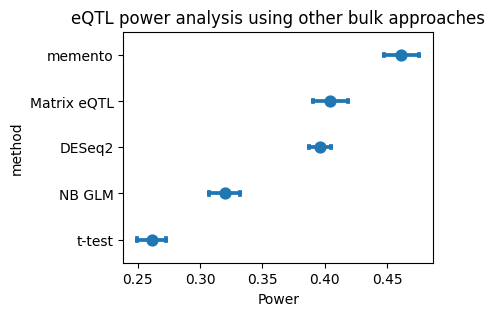

In [48]:
plt.figure(figsize=(4,3))
sns.pointplot(x='Power', y='method', data=combined_results, errorbar='se', capsize=0.05, linestyle='')
plt.title('eQTL power analysis using other bulk approaches')
plt.savefig('eqtl_bulk_methods.png', dpi=300)